<a href="https://colab.research.google.com/github/fran-scala/Intro_to_QC_beSharp/blob/main/beSharp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AWS Braket Tutorial @ beSharp

If AWS Braket is not already installed please run the following cell. For more detailed installation info visit [link](https://pypi.org/project/amazon-braket-sdk/).
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

In [1]:
!pip install amazon-braket-sdk #--quiet

In [2]:
import braket._sdk as sdk
sdk.__version__

'1.18.0'

In [3]:
# general imports
import matplotlib.pyplot as plt
%matplotlib inline
import string
import datetime as dt
import time
import numpy as np

## A brief recap

Before we start let's have a little recap of quantum computing basics. Firstly, we will give a quick look on the action of the principal quantum gates so as to understand what is done on the qubits state and then we will explain how to construct quantum circuits with di AWS Braket SDK. 

Each quantum gate can be represented by a ***unitary matrix*** that acts on the ***state vector*** of the qubits. In general, a single qubit state vector is written as 
$$\ket{\psi} = \alpha \ket{0}+\beta\ket{1}$$
where $\alpha, \beta \in \mathrm{C}$ and $\ket{0}=\begin{pmatrix}1\\0\end{pmatrix}$, $\ket{1}=\begin{pmatrix}0\\1\end{pmatrix}$.

The state of a qubit can also be visually represented onto the so-called Bloch sphere:

<img src="https://github.com/fran-scala/Intro_to_QC_beSharp/blob/main/Images/Bloch_sphere.svg.png?raw=1" alt="bloch" width="200"/>

in this representation we have $\alpha=\cos{\frac{\theta}{2}}$, $\beta=e^{i\varphi}\sin{\frac{\theta}{2}}$.

The most general quantum gate is the one that moves the state $\ket{\psi}$ on the Bloch sphere by modifying $\theta$ and $\varphi$. One can also obtain the same effect by combining rotations around each axis: we call such rotation gates $RX(\delta),\ RY(\delta),\ RZ(\delta) $. From these gates we can obtain all the main single-qubit quantum gates.

The main single-qubit quantum gates toghether with their matrix from are reported in the following table:

<img src="https://github.com/fran-scala/Intro_to_QC_beSharp/blob/main/Images/Quantum_Gates.png?raw=1" alt="quantum gates" width="500"/>


These gates act in the following way:

$X\ket{0} = \ket{1} \quad, \quad X\ket{1}=\ket{0}$

$Y\ket{0} = -i\ket{1} \quad, \quad Y\ket{1}=i\ket{0}$

$Z\ket{0} = \ket{0} \quad, \quad Z\ket{1}=-\ket{1}$

$H\ket{0} = \frac{1}{\sqrt{2}} \biggl(\ket{0}+\ket{1}\biggr)=\ket{+} \quad, \quad H\ket{1}=\frac{1}{\sqrt{2}} \biggl(\ket{0}-\ket{1}\biggr)=\ket{-}$

where $\ket{+}$ and $\ket{-}$ are highlighted since they are eigenstate of the $X$ gate.

Another important class of gates are 2-qubits quantum gates, since by the combination of 1-qubit and 2-qubit quantum gate we can obtain gates acting on an arbitrary number of qubits

In the table below we show two 2-qubit quantum gates: $CNOT, \ CZ$. 

<img src="https://github.com/fran-scala/Intro_to_QC_beSharp/blob/main/Images/Quantum_Gates_2qbs.png?raw=1" alt="quantum gates 2qb" width="500"/>

These are an example of ***controlled*** operations. A quantum gate is said to be controlled if its action is performed on a certain target qubit *if and only if* the control qubit is in state $\ket{1}$. Controlled operations allow to generate entanglement.


## Quantum circuits

At this point we have recalled all the information we will need. We can start our hands-on tutorial by seeing which are all the available gates of the SDK:

In [4]:
from braket.circuits import Gate
# print all available gates in Amazon Braket
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
#dir() returns list of the attributes and methods of any object
#the if statement is needed to only print gates (they always have at least an uppercase letter)
print(gate_set)

['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CV', 'CY', 'CZ', 'ECR', 'H', 'I', 'ISwap', 'PSwap', 'PhaseShift', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


As we can see there are tons of other gates in addition to the ones that we have presented.

In order to apply one of them to a quantum circuit you have to call the method with lower cases:

In [5]:
# import the circuit module
from braket.circuits import Circuit

#we create an empty quantum circuit
my_circuit = Circuit()# we don't need to specify the number of qubits

#we apply gates
my_circuit.h(0)
my_circuit.cnot(control=0,target=1)# we can esplicitly define control and target, 
                                    #or simply call my_circuit.cnot(0,1)

my_circuit

Circuit('instructions': [Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(0)])), Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(1)]))])

The circuit object is a list of instructions, in order to see how it looks like we can use the `print()` function:

In [6]:
print(my_circuit)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


When printing the quantum circuit structure AWS Braket shows us the following elements:

- the qubits denoted by 'q' followed by the gates applied to them;
- above and below the circuits are represented the timesteps in which the computation on a device will be sliced. 

In fact, we can only apply one gate at a time per each qubit. The timesteps length is also known as 'depth' of the circuit.

If we add to our circuit one gate on different qubits we will see that the timesteps number doesn't increase:

In [7]:
my_circuit = Circuit()
my_circuit.h(0)
my_circuit.cnot(0,1)

my_circuit.cnot(2,3)
print(my_circuit)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-
          
q2 : -C---
      |   
q3 : -X---

T  : |0|1|


We can also easily combine circuits:

In [8]:
my_circ1 = Circuit().h(0).cnot(1,0)
my_circ2 = Circuit().x(1).h(0).z(3)

combined_circ = my_circ1 + my_circ2

print(combined_circ)

T  : |0|1|2|
            
q0 : -H-X-H-
        |   
q1 : ---C-X-
            
q3 : -Z-----

T  : |0|1|2|


## Bell States execution

The so-called 'Bell states' are a well known class of maximally entangled quantum states. They are described by the following equations: 

$$\ket{\Phi^+} =  \frac{1}{\sqrt{2}} \biggl(\ket{00}+\ket{11}\biggr) \quad , \quad \quad \ket{\Phi^-} =  \frac{1}{\sqrt{2}} \biggl(\ket{00}-\ket{11}\biggr)$$ 

$$\ket{\Psi^+} =  \frac{1}{\sqrt{2}} \biggl(\ket{01}+\ket{10}\biggr) \quad , \quad \quad \ket{\Psi^-} =  \frac{1}{\sqrt{2}} \biggl(\ket{01}-\ket{10}\biggr)$$ 

The Bell state $\ket{\Phi^+}$ can be obtained applying an Hadamard gate follwed by a $CNOT$. All the others can be obtained in the same way by changing only the initial qubit state (from $\ket{00}$ to $\ket{01},\ket{10},\ket{11}$) using some $X$ gates.

![Bell](https://github.com/fran-scala/Intro_to_QC_beSharp/blob/main/Images/bell-state.png?raw=1)

So, let's build this circuit and see how to execute it.

In [9]:
bell_circ = Circuit().h(0).cnot(0,1)

Now that we built a circuit we can execute it with the `LocalSimulator`. Executing a quantum circuit means that we measure the status of each qubit after we performed the computation to see if they are in state $\ket{0}$ or $\ket{1}$. Since quantum mechanics allows superposition states we will need to repeat the computation multiple times, so we have to fix the number of desired `shots`.

In [10]:
from braket.devices import LocalSimulator

# set up device
device = LocalSimulator()

# set the number of desired shots
n_shots = 1000

# run circuit
result = device.run(bell_circ, shots=n_shots).result()
# get measurement shots
sim_counts = result.measurement_counts
# print counts
print(sim_counts)

Counter({'00': 506, '11': 494})


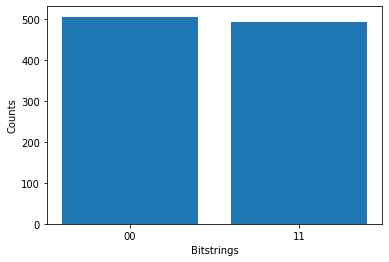

In [11]:
# plot the results
plt.bar(sim_counts.keys(), sim_counts.values())
plt.xlabel('Bitstrings')
plt.ylabel('Counts')

plt.show()

# Real hardware execution

In [ ]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = #"amazon-braket-" # the name of the bucket
my_prefix = #"folder/" # the name of the folder in the bucket

s3_folder = (my_bucket, my_prefix)

By only changing the device name one could in principle execute the quantum circuit also on real quantum hardware. 

To access a real quantum device you will need an AWS account and set up few things. Once you have done that, the syntax to load for instance the IonQ and Rigetti devices is the following:

In [13]:
#ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
#rigetti = AwsDevice('arn:aws:braket:::device/qpu/rigetti/Aspen-11')            #Aspen-11
## rigetti2 = AwsDevice('arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1')  #Aspen M-1

#device_list = [ionq, rigetti]

device_list = [LocalSimulator(),LocalSimulator()] #for now

**ATTENTION:** Often real hardware have limited kinds of gates available, always check them before trying to execute the quantum circuit.

In [14]:
for device in device_list:

  supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
  print('Gate set supported by the device:\n', supported_gates)

Gate set supported by the device:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cv', 'cy', 'cz', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']
Gate set supported by the device:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cv', 'cy', 'cz', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']


Let's execute the Bell circuit on some different hardware and see the different performances.

In [15]:
#create some useful lists
task_list = []
counts_list = []

In [16]:
# set the number of desired shots
n_shots = 1000


for device in device_list:
  # run circuit
  task = device.run(bell_circ, shots=n_shots).result()
  #stack task id
  #task_list.append(task.id) #task.id only works with online devices
  
  counts = task.measurement_counts#cancella questa riga quando hai hardware reale attivo

  counts_list.append(counts)#cancella questa riga quando hai hardware reale attivo
#save tasks
#np.save('real_hdw_bell_tasks_{}'.format(dt.datetime.today().isoformat()),task_list)

In [17]:
#retrieving the execution results from the cloud
for task_id in task_list:
    task_load = AwsQuantumTask(arn=task_id)
    result = task_load.result()
    # get measurement shots
    counts = result.measurement_counts
    counts_list.append(counts)

We can now see if there are any differences in the measurement counts using different hardware implementations:

In [18]:
keys = [np.binary_repr(i,  width=2) for i in range(2**2)]
print(keys)

['00', '01', '10', '11']


In [19]:
#quando hai hardware reale cancella la prima parte della cella

D={'11':500, '00':250, '10':250, '01':0}
counts_list.append(D) # comment this
#counts_list.append(sim_counts) ##uncomment this

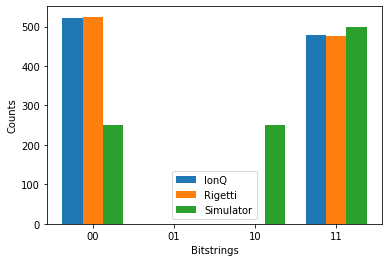

In [20]:
device_names = ['IonQ', 'Rigetti', 'Simulator']

width = 0.25  # the width of the bars

fig, ax = plt.subplots()
for index, counts in enumerate(counts_list):
  rects = ax.bar(np.array(range(len(keys)))+(index-1)*width, [counts.get(key,0) for key in keys], width, label=device_names[index])
  plt.xticks(range(len(D)), keys)


plt.xlabel('Bitstrings')
plt.ylabel('Counts')

plt.legend()
plt.show()

## Other circuit outputs

Working with real quantum hardware allow us to get as a result of the computation  only the shot measurements. On the other hand, with simulators we can obtain more information about the computation and evaluate different quantities, such as the full output-state vector, amplitudes and expectation values of certain observables. To do so, we can append the desired additional result types to the circuit before submitting it to run.

In [21]:
from braket.circuits import Observable

device = LocalSimulator()

my_circuit = Circuit().x(0).h(1).cnot(0,1)

my_circuit.state_vector()
# add the Z \otimes Z expectation value
my_circuit.expectation(Observable.Z() @ Observable.Z(), target=[0,1])
# add the amplitude for |11>
my_circuit.amplitude(state=["11"])
# print circuit including requested result types
print(my_circuit)

T  : |0|1|  Result Types  |
                           
q0 : -X-C-Expectation(Z@Z)-
        | |                
q1 : -H-X-Expectation(Z@Z)-

T  : |0|1|  Result Types  |

Additional result types: StateVector, Amplitude(11)


In this case we can see that when printing our circuit also the additional result types are shown.

**ATTENTION:** Classical simulators are powerful tools, but they can really struggle when trying to simulate an excessive number of qubits. The dimension of the space scales as $2^N$ where $N$ is the number of qubits.

In [22]:
# run the circuit and output the results
task = device.run(my_circuit, shots=0)
result = task.result()

# print results
print("Final EXACT simulated state vector:\n{}\n".format(result.values[0]))
print("Expectation value of the observable <ZZ>:{}\n".format( result.values[1]))
print("Amplitude of the component |11> of the state:{}\n".format( result.values[2]))

Final EXACT simulated state vector:
[0.        +0.j 0.        +0.j 0.70710678+0.j 0.70710678+0.j]

Expectation value of the observable <ZZ>:0.0

Amplitude of the component |11> of the state:{'11': (0.7071067811865475+0j)}



## Deutsch-Josza

In the [Deutsch–Jozsa](https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm) problem, we are given an ''oracle'' that implements some function $ f : \{0,1\}^{n}\rightarrow \{0,1\}$. The function takes n-digit binary values as input and produces either a 0 or a 1 as output for each such value. We are promised that the function is either **constant** (0 on all outputs or 1 on all outputs) or **balanced** (returns 1 for half of the input domain and 0 for the other half). The task then is to determine if $f$ is constant or balanced by using the oracle. Thanks to the power of quantum computing we can find out the function nature by **executing** the algorithm **only once**.

The algorith circuit is the following:

<img src="https://github.com/fran-scala/Intro_to_QC_beSharp/blob/main/Images/Deutsch-Jozsa-algorithm-quantum-circuit.png?raw=1" alt="d-j" width="500"/>

In the following cell we show how to implement the Deutsch–Jozsa algorithm in the case of $n=2$.

In [24]:
##change the commented line below to change the oracle

#controls = [0] #balanced
controls = [1,1] #constant

n=2

#we define the oracle 
def oracle():
    oracle_circ = Circuit()

    for i in controls:
        oracle_circ.cnot(i,n)
    return oracle_circ

def dj_algorithm():
    """Implements the Deutsch Jozsa algorithm."""
    
    dj_circuit = Circuit()
    
    dj_circuit.x(n) #the last qubit must be in state |1>
                    #psi_0
    
    for i in range(n+1):
        dj_circuit.h(i) # we create equal superposition
                        #psi_1
    
    oracle_circ = oracle()  
    
    dj_circuit += oracle_circ # psi_2

    for i in range(n):
        dj_circuit.h(i) # psi_3
    
    #we now execute the circuit
    device = LocalSimulator()

    # set the number of desired shots
    n_shots = 1 #we want to determine the nature of the function in 1 shot

    # run circuit
    result = device.run(dj_circuit, shots=n_shots).result()
    # get measurement shots
    count = result.measurement_counts
    meas_outcome = list(count.keys())[0]
    
    s = 0
    for i in range(n): # we need to take into account only the first n outcomes
        s += int(meas_outcome[i])
        
    
    # From count (a single call to the circuit), determine whether the function is constant or balanced.
    if s==0:
        return 'constant'
    else:
        return 'balanced'
    

print(dj_algorithm())

constant
